In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
user_enga =  pd.read_csv('takehome_user_engagement.csv')

In [3]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [4]:
user_enga['time_stamp'] = pd.to_datetime(user_enga.time_stamp)

**Findig the adopted user**

In [5]:
user_enga['date'] = user_enga['time_stamp'].dt.normalize()
user_enga = user_enga.sort_values(by='date')
dates = user_enga.groupby('user_id').date.unique().reset_index()
dates['adopted'] = 0
for ind, row in dates.iterrows():
    days = row['date']
    for d1, d3 in zip(days[:-2], days[2:]):
        if ((d3 - d1) < np.timedelta64(7, 'D')):
            dates.at[ind, 'adopted'] = 1
            break

**Merging the two dataframes**

In [6]:
users = pd.merge(users, dates[['user_id','adopted']], left_on='object_id',
                 right_on='user_id', how='left')

The users who never logged in are assumed non adopted as well.

In [7]:
users.at[users.adopted.isna(), 'adopted'] = 0

In [8]:
users['adopted'] = users['adopted'].astype('int')

In [9]:
users.adopted.value_counts(normalize=1)

0    0.8665
1    0.1335
Name: adopted, dtype: float64

**Deleting non-relevant columns**

In [10]:
users.drop(columns=['user_id', 'name',
                    'last_session_creation_time'], inplace=True)

In [11]:
users.columns

Index(['object_id', 'creation_time', 'email', 'creation_source',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted'],
      dtype='object')

**Creating some additional columns**

a- If the user was not invited, we assign 0 to the corresponding entry in the 'invited_by_user_id', as an indicator that the user was not invited by anyone.

In [12]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

b- Extracting the year, month and day from the creation time.

In [13]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [14]:
users = users.assign(year=users['creation_time'].apply(lambda s: s.year))
users = users.assign(month=users['creation_time'].apply(lambda s: s.month))
users = users.assign(day=users['creation_time'].apply(lambda s: s.day))
users = users.assign(nday=users['creation_time'].apply(lambda s: s.day_name()))
users = users.assign(hour=users['creation_time'].apply(lambda s: s.hour))

c- Extracting the email domain

In [15]:
users['email'] = users['email'].apply(lambda s:s.split('@')[1].split('.')[0])

In [16]:
users['email'].value_counts()[0:10]

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
mumdc            2
rerwl            2
oqpze            2
xvnbr            2
Name: email, dtype: int64

In [17]:
imp_domain = list(users['email'].value_counts()[0:6].index)
users.at[~users.email.isin(imp_domain), 'email'] = 'Other'

In [18]:
users['email'].value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
Other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

d- Adding a column for the size of the organization to which the user belongs 

In [19]:
org_sizes = users.org_id.value_counts().reset_index().rename(columns={'org_id':'org_size','index':'org_id'})
users = users.merge(org_sizes, on='org_id')

**Some Data Visualizations**

In [20]:
users.columns

Index(['object_id', 'creation_time', 'email', 'creation_source',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'year', 'month', 'day', 'nday', 'hour',
       'org_size'],
      dtype='object')

In [21]:
cols = ['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']

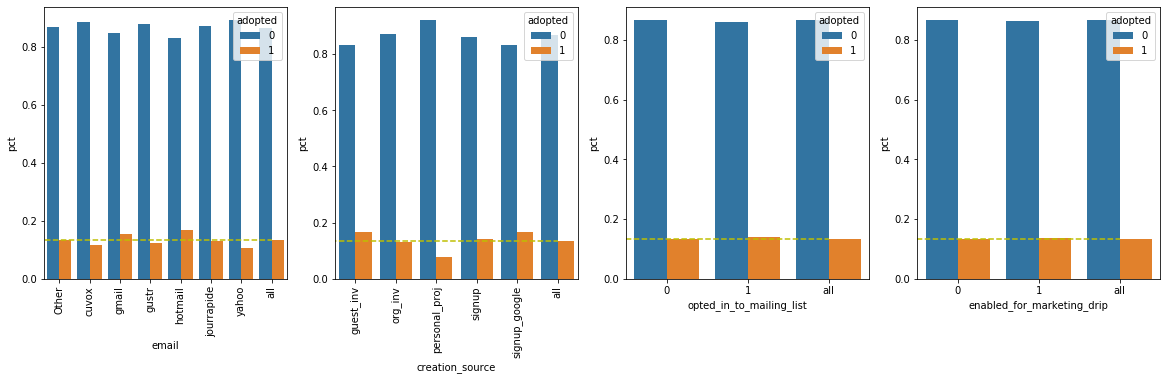

In [22]:
fig, axes = plt.subplots(1, 4, figsize=[20, 5])

for col, ax in zip(cols, axes):
    source = users.groupby(col).adopted.value_counts(
        normalize=True).reset_index(col).rename(columns={'adopted': 'pct'}).reset_index()
    whole = users.adopted.value_counts(normalize=True).reset_index()
    whole[col] = 'all'
    whole = whole.rename(columns={'adopted': 'pct', 'index': 'adopted'})
    source = pd.concat([source, whole], sort=True)
    ax.hlines(xmin=-1, xmax=len(users[col].unique()), y=sum(
        users.adopted == 1)/len(users), color='y', linestyle='--')
    sns.barplot(x=col, y='pct', data=source, hue='adopted', ax=ax)

axes[1].set_xticklabels(['guest_inv', 'org_inv', 'personal_proj',
                         'signup', 'signup_google', 'all'], rotation=90)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)
plt.show()

- When considering the features: "opted in to mailing list", and "enabled for marketing drip", there is no difference in the distribution of the target variable vs the distribution of the target variable in the whole data.
- Some slight differences observed for the features: creation_source and email, (in particular, the following categories: guest_invitation, signup_google, personal_proj, hotmail, gmail and yahoo, showed the great differences).

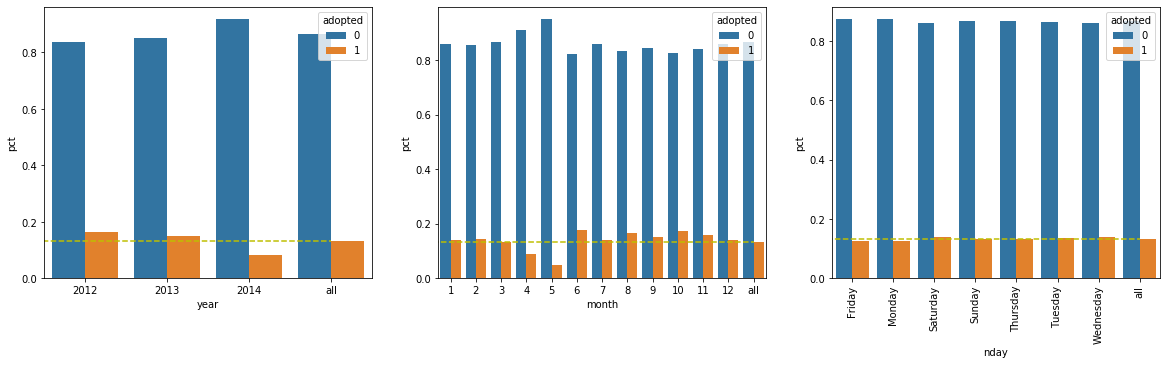

In [23]:
cols = ['year', 'month', 'nday']
fig, axes = plt.subplots(1, 3, figsize=[20, 5])

for col, ax in zip(cols, axes):
    source = users.groupby(col).adopted.value_counts(
        normalize=True).reset_index(col).rename(columns={'adopted': 'pct'}).reset_index()
    whole = users.adopted.value_counts(normalize=True).reset_index()
    whole[col] = 'all'
    whole = whole.rename(columns={'adopted': 'pct', 'index': 'adopted'})
    source = pd.concat([source, whole], sort=True)
    ax.hlines(xmin=-1, xmax=len(users[col].unique()), y=sum(
        users.adopted == 1)/len(users), color='y', linestyle='--')
    sns.barplot(x=col, y='pct', data=source, hue='adopted', ax=ax)

axes[-1].set_xticklabels(axes[-1].get_xticklabels(),rotation=90)
plt.show()

We are checking the month and year of activation time in order to check if there is association between adoption rate and some seasonal events. Note that for the year of 2014, we have dates spanning the first half of the year (month 1 till end of 5) and for 2012 we have dates spanning the last half of the year (month 6 till end of year). 

From the plots, most of the differences are seen for the year 2012 and 2014 and for the months 4, 5, 6, 8, 10.

No much differences observed for the day name feature.

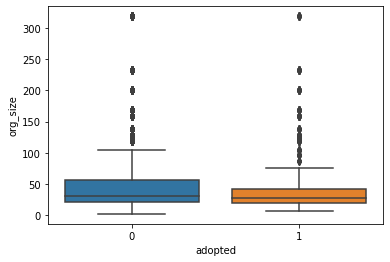

In [24]:
sns.boxplot(x="adopted", y="org_size", data=users)
plt.show()

The organization sizes for non adopted users are more spread out and include more high sizes.

**Computing the cramer's V coefficicents**
To measure the statistical significance of these observations as well as for the reamining catgeorical variables with high cardinality, we compute the cramer'v coefficient for each categorical columns.

In [25]:
from scipy.stats import chi2_contingency
def cram_cont(chi2, table):
    ntot = table.sum().sum()
    nrow, ncol = table.shape
    phi_sqr = chi2/ntot
    phi_sqr_tilde = max(0, phi_sqr-(nrow-1)*(ncol-1)/(ntot-1))
    ncol_tilde = ncol-((ncol-1)**2)/((ntot-1))
    nrow_tilde = nrow-((nrow-1)**2)/((ntot-1))
    cramer = np.sqrt(phi_sqr_tilde/min(ncol_tilde-1, nrow_tilde-1))
    cont = np.sqrt(chi2/(chi2+ntot))
    return (cramer, cont)
    plt.show()# Crash Features

colnames = ['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
            'invited_by_user_id',  'year', 'month', 'day', 'nday','hour']

# Initialize an empty array that will have the results for each feature
values = np.empty(shape=[3, len(colnames)])
col = 0

# Loop over the features and save chi2, pvalue, cramer's v and contingency coefs
for colname in colnames:
    table = pd.crosstab(users.adopted, users[colname])
    chi2, p, dof, expected = chi2_contingency(table)
    values[0][col] = chi2
    values[1][col] = p
    cramer, cont = cram_cont(chi2, table)
    values[2][col] = cramer
    col = col + 1

# Create a dataframe for the results
results = pd.DataFrame(values)
results.columns = colnames
results.rename(index={0: "Chi2", 1: "P-val",2: "Cramer's V"}, inplace=True)
results.T.sort_values(by="Cramer's V", ascending=False)

,Chi2,P-val,Cramer's V
invited_by_user_id,2771.966153,2.267052e-03,0.131583
month,151.196899,8.486707e-27,0.108092
org_id,539.010304,4.297528e-05,0.101236
year,111.060261,7.648401e-25,0.095337
creation_source,92.284640,4.305822e-19,0.085777
email,44.388734,6.189426e-08,0.056562
hour,32.847449,8.376189e-02,0.028645
day,34.544251,2.596004e-01,0.019455
opted_in_to_mailing_list,0.732772,3.919862e-01,0.000000
enabled_for_marketing_drip,0.222798,6.369164e-01,0.000000


As already illustrated, the columns "opted_in_to_mailing_list", "enabled_for_marketing_drip" and name of the day have no association with the target variable (their corresponding Cramer's V coefficient is zero). This is why, we are not going to consider them next when building the predictive model. 

In [26]:
users.columns

Index(['object_id', 'creation_time', 'email', 'creation_source',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'year', 'month', 'day', 'nday', 'hour',
       'org_size'],
      dtype='object')

**Building the predictive model**

In [27]:
X = users[['creation_source', 'email', 'org_id','invited_by_user_id', 'year', 'month', 'day','hour','org_size']]
Y = users.adopted

In [28]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision
from sklearn.metrics import recall_score as recall, f1_score as f1
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y)

**Encoding the nominal categorical columns with low cardinality with one hot encoding**

In [29]:
Xtrain = pd.get_dummies(Xtrain, columns=['creation_source','email'])

In [30]:
Xtrain['year'] = Xtrain['year'] - 2011 # entries: 1 means 2012, 2 means 2013 and so on

**Defining our class-validation function**
This function will be used to compare between the models. Note that categorical variables with high cardinality are encoded with leave-one-out encoder and also oversampling is used to target imbalances in the data.

In [31]:
def cv_score(clf, x, y, cv, cols_to_encode, cat_range, num_range, scale=False):
    result = np.zeros((cv, 4))
    i = 0
    rus = SMOTENC(cat_range,random_state=0)
    
    # split data into train/test groups, 'cv' times
    for train, test in StratifiedKFold(cv).split(x, y):
        x_train, y_train = x.iloc[train], y[train]
        encoder = ce.leave_one_out.LeaveOneOutEncoder(cols=cols_to_encode).fit(
            x_train, y_train)
        x_trans = encoder.transform(x_train)
        x_test = encoder.transform(x.iloc[test])
        if (scale == True):
            scaler = StandardScaler()
            x_trans.at[:,0:7] = scaler.fit_transform(x_trans.iloc[:,num_range])
            x_test.at[:,0:7] = scaler.transform(x_test.iloc[:,num_range])
        x_trans, y_train = rus.fit_resample(x_trans, y_train)
        clf.fit(x_trans, y_train)  # fit
        ypred = clf.predict(x_test)
        result[i, 0] = accuracy(ypred, y[test])
        result[i, 1] = precision(ypred, y[test])
        result[i, 2] = recall(ypred, y[test])
        result[i, 3] = f1(ypred, y[test])
        i = i + 1
    return np.mean(result, axis=0)

Models to try

In [32]:
models=[SGDClassifier(loss='log'), RandomForestClassifier(random_state=1), GradientBoostingClassifier(random_state=2)]

In [33]:
col_names =['org_id','invited_by_user_id']
results = []
for model in models:
    result = cv_score(model, Xtrain, Ytrain.values, cols_to_encode=col_names, cv=5, scale=True,
                      cat_range=range(7,18), num_range=range(0,7))
    results.append(result)

In [34]:
results = pd.DataFrame(results)
results.columns = ["Accuracy", "Precision", "Recall", "F1"]
results.rename(index={0: "Logistic Regression", 1: "Random Forest", 2: "Gradient Boosting"}, inplace=True)
results

,Accuracy,Precision,Recall,F1
Logistic Regression,0.750104,0.226210,0.170092,0.193363
Random Forest,0.805937,0.127940,0.179955,0.149260
Gradient Boosting,0.743021,0.256645,0.178081,0.210011


We choose the best model based on its F1-score: Gradient Boosting

**Final Model Performance**

In [36]:
clf = GradientBoostingClassifier(random_state=2)
rus = SMOTENC(range(7,18), random_state=0)


Xtest = pd.get_dummies(Xtest, columns=['creation_source','email'])
Xtest['year'] = Xtest['year'] - 2011 

# Encode the data using leave-one-out Encoder
encoder = ce.leave_one_out.LeaveOneOutEncoder(cols=col_names).fit(Xtrain, Ytrain.values)
x_trans = encoder.transform(Xtrain)
x_test = encoder.transform(Xtest)
scaler = StandardScaler()
x_trans.at[:,0:7] = scaler.fit_transform(x_trans.iloc[:,0:7])
x_test.at[:,0:7] = scaler.transform(x_test.iloc[:,0:7])
x_trans, y_train = rus.fit_resample(x_trans, Ytrain.values)
# Fit the model
clf.fit(x_trans, y_train)
# Test the model on the test set
ypred = clf.predict(x_test)
print('Accuracy:', accuracy(ypred, Ytest.values))
print("Precision:", precision(ypred, Ytest.values))
print("Recall:", recall(ypred, Ytest.values))
print("F1:", f1(ypred, Ytest.values))

Accuracy: 0.72625
Precision: 0.271875
Recall: 0.17025440313111545
F1: 0.20938628158844763


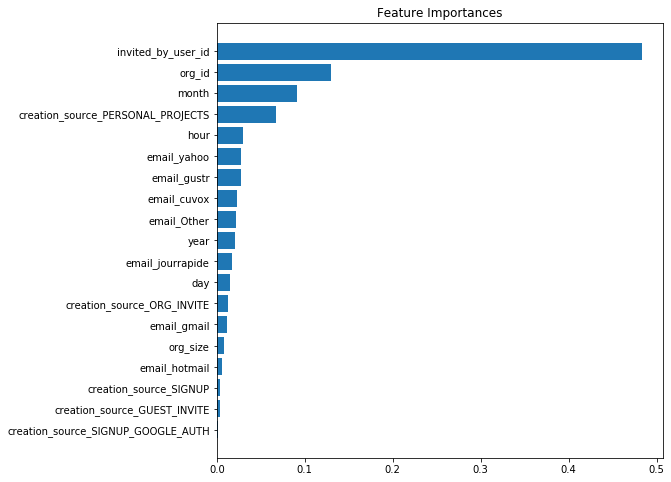

In [37]:
feature_names = Xtrain.columns
sorted_idx = clf.feature_importances_.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=[8,8])
ax.barh(y_ticks, clf.feature_importances_[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Feature Importances")
plt.show()